In [1]:
import os
import re
from torchvggish import vggish, vggish_input
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
MUSIC_DIR="music/sampled/"
EMBEDDING_MODEL = vggish()
EMBEDDING_MODEL.eval()
SONG_LENGTH = 30 # length of samples
SAMPLES_PER_CAT=60

## Audio Examples

In [13]:
path1=MUSIC_DIR+"cat_jonas/Fall Out Boy - Hum Hallelujah.wav"
path2=MUSIC_DIR+"cat_philipp/Synestia, Disembodied Tyrant - Winter.wav"

song1,sr1 = librosa.load(path1)
song2,sr2 = librosa.load(path2)

name1 = path1.split("/")[3]
name2 = path2.split("/")[3]

ipd.display(ipd.Audio(data=song1, rate=sr1))
ipd.display(ipd.Audio(data=song2, rate=sr2))

## Audio Representation

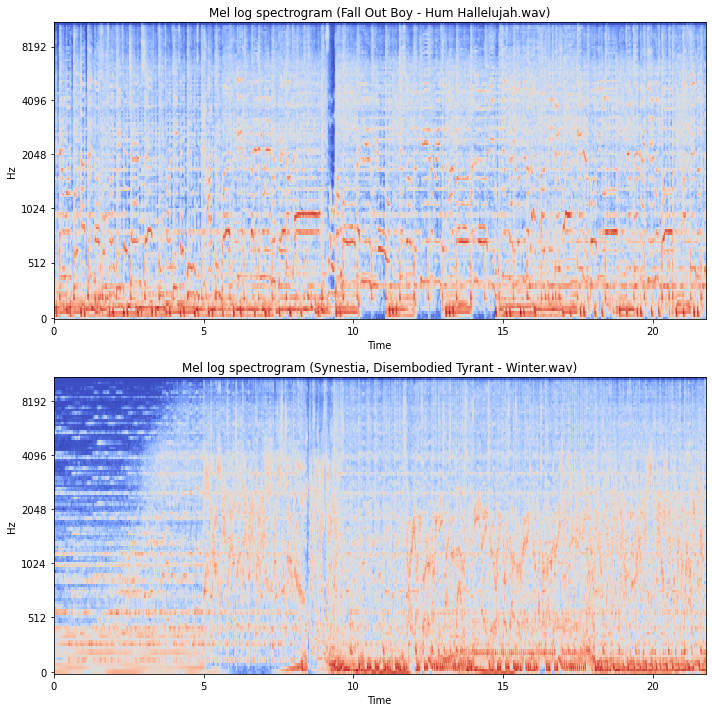

In [14]:
def getLogMelSpec(path):
    song,sr = librosa.load(path,sr=16000,mono=True)
    song_spec=librosa.feature.melspectrogram(y=song, sr=sr,window="hann")
    return np.log(song_spec+0.01),sr

song1_spec_data,sr1=getLogMelSpec(path1)
song2_spec_data,sr2=getLogMelSpec(path2)

fig, (ax1,ax2) = plt.subplots(nrows=2)
fig.set_figwidth(10)
fig.set_figheight(10)

img = librosa.display.specshow(song1_spec_data, y_axis='mel', x_axis='time', ax=ax1)
ax1.set(title=f'Mel log spectrogram ({name1})');
img = librosa.display.specshow(song2_spec_data, y_axis='mel', x_axis='time', ax=ax2)
ax2.set(title=f'Mel log spectrogram ({name2})');
fig.tight_layout()

## Classification

In [5]:
def readFolder2Embedding(path):

    songs = os.listdir(path)

    songs= np.random.choice(songs,size=60,replace=False)

    # vggish output embedding has length 128
    data = np.zeros((SAMPLES_PER_CAT, SONG_LENGTH*128))
    labels = []
    names =  []
    for i, song in enumerate(songs):
        print(f"Learning Embedding for {song}")
        embedding = EMBEDDING_MODEL.forward(
            vggish_input.wavfile_to_examples(path+ "/" +song))
        # normalize length, convert to numpy array and flatten the feature array
        converted_embedding = embedding.detach().numpy()[
            :SONG_LENGTH, :].flatten()
        data[i, :] = converted_embedding
        # get label/category name from directory name
        labels.append(re.match(r".*cat_(.*)", path)[1])
        names.append(song)
    return data, labels, names

In [6]:
def readIn():
    directories = sorted(os.listdir(MUSIC_DIR))
    data = np.empty((0, SONG_LENGTH*128))
    label = []
    names=[]
    for directory in directories:
        dir_data, dir_label, dir_names= readFolder2Embedding(
            MUSIC_DIR+directory)
        data = np.concatenate((data, dir_data), axis=0)
        label += dir_label
        names+=dir_names
    print("All data read in successfully!")
    return data, label, names

In [7]:
# def classify(classifier, filepath):
#     print("Predicting label for" + filepath + "...")
#     embedding = EMBEDDING_MODEL.forward(vggish_input.wavfile_to_examples(filepath))
#     converted_embedding = embedding.detach().numpy()[
#         :SONG_LENGTH, :].flatten()
#     return classifier.predict(converted_embedding.reshape(1, -1))

In [8]:
def test(classifier, data: list, labels):
    predictions=[]
    wrong = []
    for i, sample in enumerate(data):
        predict = classifier.predict(sample.reshape(1, -1))
        predictions.append(predict)
        #print(predict[0] + \" \" + labels[i])\n",
        if predict[0] != labels[i]:
            wrong.append(sample)
    return accuracy_score(labels,predictions), wrong

In [9]:
data, label, names = readIn()

Learning Embedding for Billy Talent - Fallen Leaves.wav
Learning Embedding for Linkin Park - Bleed It Out.wav
Learning Embedding for Foo Fighters - The Feast and The Famine.wav
Learning Embedding for Billy Talent - Devil in a Midnight Mass.wav
Learning Embedding for Oasis - Don_t Look Back In Anger.wav
Learning Embedding for Kraftklub - Wie ich.wav
Learning Embedding for blink-182 - No Heart To Speak Of.wav
Learning Embedding for blink-182 - Going Away To College.wav
Learning Embedding for The All-American Rejects - Move Along.wav
Learning Embedding for Foo Fighters - I Am A River.wav
Learning Embedding for My Chemical Romance - Famous Last Words.wav
Learning Embedding for Billy Talent - Devil on My Shoulder.wav
Learning Embedding for blink-182 - Up All Night.wav
Learning Embedding for blink-182 - First Date.wav
Learning Embedding for Sum 41 - The Hell Song.wav
Learning Embedding for blink-182 - BAD NEWS.wav
Learning Embedding for AWOLNATION - Not Your Fault.wav
Learning Embedding for 

In [15]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.33,stratify=label)

# classifier=DecisionTreeClassifier(max_depth=20)
classifier=RandomForestClassifier(max_depth=20)

classifier.fit(x_train, y_train)
print("Training successful")

Training successful


## Evaluation

In [16]:
def get_Index(a, listb):
    for i in range(0, len(listb)):
        if np.array_equal(a, listb[i]):
            return i

In [17]:
acc, wrong = test(classifier,x_test, y_test)
print("Accuracy: "+ str(acc))
for emb in wrong:
    index = get_Index(emb, data)
    print(names[index])

Accuracy: 0.825
The All-American Rejects - Move Along.wav
Billy Talent - Devil on My Shoulder.wav
Foo Fighters - Everlong.wav
Bakkushan - Deine Helden sind tot.wav
My Chemical Romance - Sleep.wav
Annisokay - STFU.wav
My Chemical Romance - Welcome to the Black Parade.wav
